Flow to follow - PCD Denoising, downsampling, estimating normals, extracting and setting parameters, implementing ransac, automated ransac, dbscan

In [2]:
import open3d as o3d
import numpy as np
import pyvista as pv
import trimesh
import os
import sys
import matplotlib.pyplot as plt
import pymeshfix as mf
from prettytable import PrettyTable

In [2]:
#loading point cloud data
file = input()
pcd = o3d.io.read_point_cloud(file)

o3d.visualization.draw_geometries([pcd])

pcd_centre = pcd.get_center()
pcd_centre

 star_smooth100k_outliers_uniform.xyz


array([-1.07961384e+01, -1.60671615e-03,  5.93628538e+00])

In [3]:
#pcd denoising
nn = 6

nsigma = 0.05

filtered_pcd = pcd.remove_statistical_outlier(nn, nsigma)

outliers = pcd.select_by_index(filtered_pcd[1], invert = True)
outliers.paint_uniform_color([1,0,0])
filtered_pcd = filtered_pcd[0]

o3d.visualization.draw_geometries([filtered_pcd])

In [4]:
#pcd downsampling
vox_size = 0.05

downsampled_pcd = filtered_pcd.voxel_down_sample(vox_size)

o3d.visualization.draw_geometries([downsampled_pcd])

In [5]:
#estimating normals
avg_dist = np.mean(downsampled_pcd.compute_nearest_neighbor_distance())
radius_normals = avg_dist * 4

downsampled_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=30))
downsampled_pcd.orient_normals_consistent_tangent_plane(100)

o3d.visualization.draw_geometries([downsampled_pcd])

In [6]:
#ransac
pt_to_plane = 0.05

plane_model, inliers = downsampled_pcd.segment_plane(distance_threshold = pt_to_plane, ransac_n = 3, num_iterations = 1000)

[a, b, c, d] = plane_model

print(f"Plane Equation: {a:.2f}x + {b:.2f}y +{c:.2f}z + {d:.2f} = 0")

inliercloud = downsampled_pcd.select_by_index(inliers)
outliercloud = downsampled_pcd.select_by_index(inliers, invert = True)

inliercloud.paint_uniform_color([1,0,0])
outliercloud.paint_uniform_color([0.6,0.6,0.6])
o3d.visualization.draw_geometries([inliercloud, outliercloud])

Plane Equation: 0.56x + 0.59y +0.58z + 3.11 = 0
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [7]:
#automated ransac
max_plane_ind = 6
pt_to_plane_dist = 0.05

segment_models = {}
segment = {}
rest = downsampled_pcd

for i in range (max_plane_ind):
    colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold = pt_to_plane_dist, ransac_n = 3, num_iterations = 1000)
    segment[i] = rest.select_by_index(inliers)
    segment[i].paint_uniform_color(list(colors[:3]))
    rest = rest.select_by_index(inliers, invert = True)
    
o3d.visualization.draw_geometries([segment[i] for i in range (max_plane_ind)] + [rest])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [8]:
#dbscan
labels = np.array(rest.cluster_dbscan(eps = 0.5, min_points = 5))

max_labels = labels.max()
print(f"The point cloud has {max_labels +1} clusters")

colors = plt.get_cmap("tab10")(labels/(max_labels if max_labels>0 else 1))
colors[labels < 0]

rest.colors = o3d.utility.Vector3dVector(colors[:,:3])
o3d.visualization.draw_geometries([segment[i] for i in range (max_plane_ind)] + [rest])

The point cloud has 1 clusters


In [9]:
# #surface reconstruction using poisson reconstruction
# mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(downsampled_pcd, depth = 9, width = 0, scale = 1.1, linear_fit = False)
# bbox = downsampled_pcd.get_axis_aligned_bounding_box()
# mesh_cropped = mesh.crop(bbox)
# o3d.visualization.draw_geometries([mesh_cropped])

In [10]:
#surface reconstruction using bpa
avg_dist = np.mean(pcd.compute_nearest_neighbor_distance())
radius = 3*avg_dist

mesh_in = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(downsampled_pcd, o3d.utility.DoubleVector([radius, radius*2]))
o3d.visualization.draw_geometries([mesh_in])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [11]:
# #surface smoothing
mesh = mesh_in.filter_smooth_simple(number_of_iterations=1)

In [12]:
#converting open3d mesh into trimesh object
objmesh = trimesh.Trimesh(np.asarray(mesh.vertices), np.asarray(mesh.triangles), vertex_normals=np.asarray(mesh.vertex_normals))

In [13]:
objmesh.units = trimesh.units.units_from_metadata(objmesh, guess = True)
print("The mesh currently has the unit: ", objmesh.units)

if objmesh.units == None:
    objmesh.units = "mm"
    print("The mesh unit has been changed to: ", objmesh.units)
else:
    pass

The mesh currently has the unit:  inches


In [14]:
objmesh.is_watertight

False

In [15]:
brkn = trimesh.repair.broken_faces(objmesh)
print(brkn)
print("Number of faces that break the mesh are: ", len(brkn))

[13528  1675  1597 14159  1664 14197 14198 14222 14207 13835 13836 12560
 13834 13831  1574 12567 14229  1595 14139 14140 14224 13841  1673 14138
 14152  1591  1593 14208 14161  1599  7303  7278 14367  1627 11689   525
   526 14226 14186 14121  1587 14163 14166  1686 14364 14178  1612 14245
 14246 14100 14101 14102 13534  1554  1571  1572  1658 14185  1547  1557
 14369 14203 14171 12558  1671  1636  1637  1584 14216 14213  1615   538
  1625 14204 14194 14209  1621 12537  4235  4236  1568 14145  1688 14168
 11691 14173 11673  1653 14225  1622  7290  1614 13535 11666 14125 14124
 12566  1639 14175 14368  1659 11698 11699 14133 14253  1601  1643  1644
  1645  1647  1646 14241  1630 13526 13525  4249 14212  1633 14205 14200
  4241  4247 14153 14231 14232 11661   535 14361  1606  4245  7301  7300
  7308  4233 13508 14365 14182 14119  1342 13809  4237 14219 14218  1655
 14143 14157  1667 14191 14192 14236 14237 14235  1669 14188  7309 14155
  1580  7298 14362  4234 13530  1576 14116  1604 14

In [16]:
trimesh.scene.lighting.SpotLight(objmesh, intensity = 50)
objmesh.show()

Mesh is not continuous. Holes in the mesh are highlighted in red:


C:\Users\vaish\anaconda3\lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\vaish\anaconda3\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


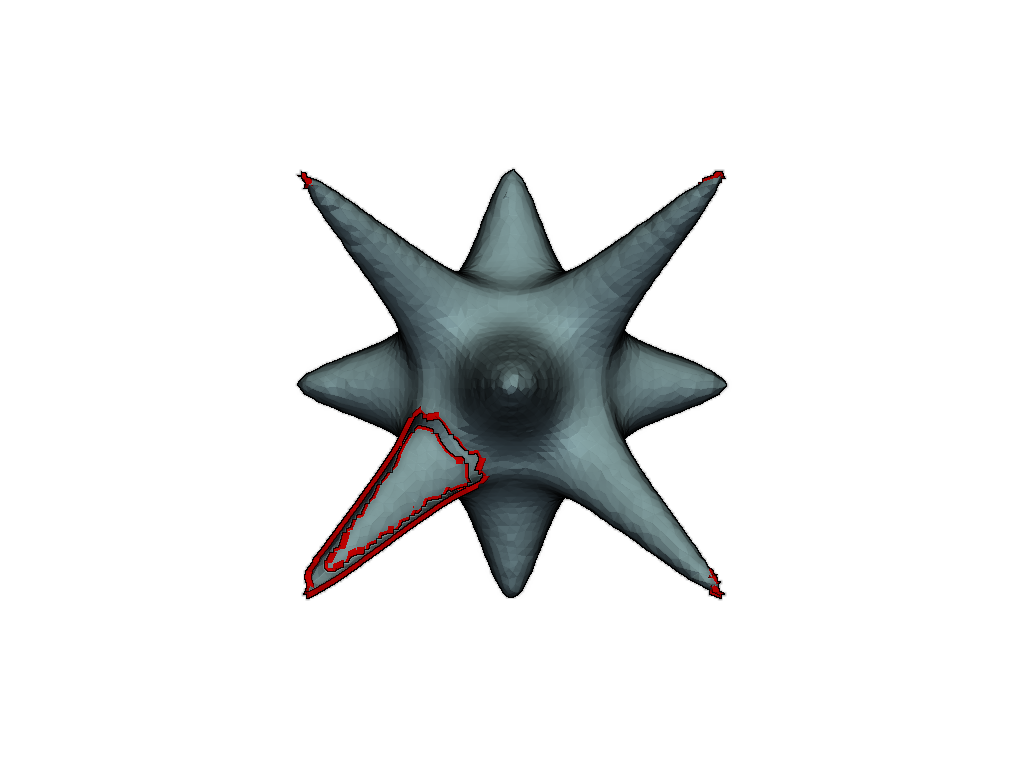

In [17]:
#displaying broken facets/edges of the model
if not objmesh.is_watertight:
    print("Mesh is not continuous. Holes in the mesh are highlighted in red:")
    objpv = pv.wrap(objmesh)
    meshfix = mf.MeshFix(objpv)
    holes = meshfix.extract_holes()
    # Render the mesh and outline the holes
    p = pv.Plotter()
    p.add_mesh(objpv, color=True)
    p.add_mesh(holes, color="r", line_width=8)
    p.enable_eye_dome_lighting()  # helps depth perception
    p.camera_position = 'xz'
    p.show(jupyter_backend='trame')
else:
    print("Mesh is already watertight")
    
    

In [18]:
if not objmesh.is_watertight:
    meshfix.repair(verbose=True)
    repaired = meshfix.mesh
    print(repaired)
    faces_as_array = repaired.faces.reshape((repaired.n_faces, 4))[:, 1:] 
    acl = trimesh.Trimesh(repaired.points, faces_as_array)
    acl.units = trimesh.units.units_from_metadata(acl, guess = True)
else:
    acl = objmesh

acl.show(smooth = False)
    

Removed 1 small components
Patching holes...
Patched 11 holes
Fixing degeneracies and intersections
PolyData (0x21f36784e20)
  N Cells:    14618
  N Points:   7311
  N Strips:   0
  X Bounds:   -1.195e+01, -9.646e+00
  Y Bounds:   -1.142e+00, 1.139e+00
  Z Bounds:   4.791e+00, 7.087e+00
  N Arrays:   0


C:\Users\vaish\anaconda3\lib\site-packages\pyvista\core\pointset.py:1129: PyVistaDeprecationWarning: The current behavior of `pv.PolyData.n_faces` has been deprecated.
                Use `pv.PolyData.n_cells` or `pv.PolyData.n_faces_strict` instead.
                See the documentation in '`pv.PolyData.n_faces` for more information.
  warnings.warn(


In [19]:
print("Mesh is watertight: ",acl.is_watertight)
print("Volume of the object is: ",acl.volume, acl.units + "³")
print("Area of the object is: ",acl.area, acl.units + "²")

Mesh is watertight:  True
Volume of the object is:  1.9716836794799875 inches³
Area of the object is:  12.793998764823636 inches²


In [20]:
vertacl = np.array(acl.vertices)
# # Initialize variables to store the minimum and maximum Feret values
# bmin_acl = float('inf')
# bmax_acl = 0.0

# # Iterate through all edges of the mesh
# for edge in acl.edges_unique:
#     edge_length = np.linalg.norm(vertacl[edge[0]] - vertacl[edge[1]])
    
#     bmin_acl = min(bmin_acl, edge_length)
#     bmax_acl = max(bmax_acl, edge_length)

# print("Feret Min:", bmin_acl, acl.units)
# print("Feret Max:", bmax_acl, acl.units)

In [21]:
covmat_acl = np.cov(vertacl, rowvar=False)

eigvalacl, eigvecacl = np.linalg.eigh(covmat_acl)

sortindacl = np.argsort(eigvalacl)[::-1]
eigvecacl_sorted = eigvecacl[:, sortindacl]
eigvalacl_sorted = eigvalacl[sortindacl]

majaxis_acl = np.abs(eigvecacl_sorted[:, 0])
majlen_acl = np.sqrt(eigvalacl_sorted[0])

minaxis_acl = np.abs(eigvecacl_sorted[:, 2]) 
minlen_acl = np.sqrt(eigvalacl_sorted[2])

print("Major Axis:", majaxis_acl)
print("Major Length:", majlen_acl, acl.units)
print("Minor Axis:", minaxis_acl)
print("Minor Length:", minlen_acl, acl.units)

Major Axis: [0.95864439 0.27006879 0.08979856]
Major Length: 0.5519292755999872 inches
Minor Axis: [0.23265219 0.92535411 0.29932046]
Minor Length: 0.5489076129863693 inches


In [22]:
#code for table of contents for closure set (acl)
acl_table = PrettyTable(["Parameter", "Value", "Unit"])
acl_table.add_row(["No open surfaces", acl.is_watertight, "-"])
# acl_table.add_row(["Feret max", bmax_acl, acl.units])
# acl_table.add_row(["Feret min", bmin_acl, acl.units])
acl_table.add_row(["Major axis", majlen_acl, acl.units])
acl_table.add_row(["Minor axis", minlen_acl, acl.units])
acl_table.add_row(["Lebesgue Measure", acl.volume, acl.units + "³"])
acl_table.add_row(["Minkowski Functional", acl.area, acl.units + "²"])
print(acl_table)

+----------------------+--------------------+---------+
|      Parameter       |       Value        |   Unit  |
+----------------------+--------------------+---------+
|   No open surfaces   |        True        |    -    |
|      Major axis      | 0.5519292755999872 |  inches |
|      Minor axis      | 0.5489076129863693 |  inches |
|   Lebesgue Measure   | 1.9716836794799875 | inches³ |
| Minkowski Functional | 12.793998764823636 | inches² |
+----------------------+--------------------+---------+


In [23]:
# Compute the minimum oriented bounding box
abh = acl.bounding_box_oriented

# Access the vertices and rotation matrix of the bounding box
abh_vertices = abh.vertices
abh_rotation_matrix = abh.primitive.transform
abh.units = trimesh.units.units_from_metadata(abh, guess = True)

# Visualize the mesh and the bounding box
scene = trimesh.Scene([acl, abh.as_outline()])
scene.show()
#current the bounding box outline is in white colour, looking for a function that can change the colour, rotating the component can help in seeing the fine white edges

In [24]:
print("Bounding hyperrectangle is watertight: ",abh.is_watertight)
print("Volume of the bounding hyperrectangle is: ", abh.volume, abh.units + "³")
print("Area of the bounding hyperrectangle is: ",abh.area, abh.units + "²")

Bounding hyperrectangle is watertight:  True
Volume of the bounding hyperrectangle is:  11.774772342130719 inches³
Area of the bounding hyperrectangle is:  31.054962765185536 inches²


In [25]:
vertabh = np.array(abh.vertices)
# Initialize variables to store the minimum and maximum Feret values
bmin_abh = float('inf')
bmax_abh = 0.0

 # Iterate through all edges of the mesh
for edge in abh.edges_unique:
    edge_length = np.linalg.norm(vertabh[edge[0]] - vertabh[edge[1]])
    
    bmin_abh = min(bmin_abh, edge_length)
    bmax_abh = max(bmax_abh, edge_length)
print("Feret Min:", bmin_abh, abh.units)
print("Feret Max:", bmax_abh, abh.units)

Feret Min: 2.2543071125148004 inches
Feret Max: 3.232151607584107 inches


In [26]:
covmat_abh = np.cov(vertabh, rowvar=False)

eigvalabh, eigvecabh = np.linalg.eigh(covmat_abh)

sortindabh = np.argsort(eigvalabh)[::-1]
eigvecabh_sorted = eigvecabh[:, sortindabh]
eigvalabh_sorted = eigvalabh[sortindabh]

majaxis_abh = np.abs(eigvecabh_sorted[:, 0])
majlen_abh = np.sqrt(eigvalabh_sorted[0])

minaxis_abh = np.abs(eigvecabh_sorted[:, 2]) 
minlen_abh = np.sqrt(eigvalabh_sorted[2])

print("Major Axis:", majaxis_abh)
print("Major Length:", majlen_abh, abh.units)
print("Minor Axis:", minaxis_abh)
print("Minor Length:", minlen_abh, abh.units)

Major Axis: [0.01942479 0.01566488 0.9996886 ]
Major Length: 1.2265355567109835 inches
Minor Axis: [0.15082212 0.98838932 0.01841842]
Minor Length: 1.2049778370854343 inches


In [27]:
#code for table of contents for bounding hyperrectangle (abh)
abh_table = PrettyTable(["Parameter", "Value", "Unit"])
abh_table.add_row(["No open surfaces", abh.is_watertight, "-"])
# abh_table.add_row(["Feret max", bmax_abh, abh.units])
# abh_table.add_row(["Feret min", bmin_abh, abh.units])
abh_table.add_row(["Major axis", majlen_abh, abh.units])
abh_table.add_row(["Minor axis", minlen_abh, abh.units])
abh_table.add_row(["Lebesgue Measure", abh.volume, abh.units + "³"])
abh_table.add_row(["Minkowski Functional", abh.area, abh.units + "²"])
print(abh_table)

+----------------------+--------------------+---------+
|      Parameter       |       Value        |   Unit  |
+----------------------+--------------------+---------+
|   No open surfaces   |        True        |    -    |
|      Major axis      | 1.2265355567109835 |  inches |
|      Minor axis      | 1.2049778370854343 |  inches |
|   Lebesgue Measure   | 11.774772342130719 | inches³ |
| Minkowski Functional | 31.054962765185536 | inches² |
+----------------------+--------------------+---------+


In [28]:
origin = acl.centroid
print(acl.centroid)

[-1.07961306e+01  4.50914546e-03  5.93822037e+00]


In [29]:
ach = trimesh.convex.convex_hull(acl)
ach.units = trimesh.units.units_from_metadata(ach, guess = True)
ach.show(smooth = False)

In [30]:
print("Convex hull is watertight: ",ach.is_watertight)
print("Volume of the convex hull is: ",ach.volume, ach.units + "³")
print("Area of the convex hull is: ",ach.area, ach.units + "²")

Convex hull is watertight:  True
Volume of the convex hull is:  8.787385585417216 inches³
Area of the convex hull is:  23.280979575327777 inches²


In [31]:
vertach = np.array(ach.vertices)
#  # Initialize variables to store the minimum and maximum Feret values
# bmin_ach = float('inf')
# bmax_ach = 0.0

# # Iterate through all edges of the mesh
# for edge in ach.edges_unique:
#     edge_length = np.linalg.norm(vertach[edge[0]] - vertach[edge[1]])
   
#     bmin_ach = min(bmin_ach, edge_length)
#     bmax_ach = max(bmax_ach, edge_length)
# print("Feret Min:", bmin_ach, ach.units)
# print("Feret Max:", bmax_ach, ach.units)

In [32]:
covmat_ach = np.cov(vertach, rowvar=False)

eigvalach, eigvecach = np.linalg.eigh(covmat_ach)

sortindach = np.argsort(eigvalach)[::-1]
eigvecach_sorted = eigvecach[:, sortindach]
eigvalach_sorted = eigvalach[sortindach]

majaxis_ach = np.abs(eigvecach_sorted[:, 0])
majlen_ach = np.sqrt(eigvalach_sorted[0])

minaxis_ach = np.abs(eigvecach_sorted[:, 2])
minlen_ach = np.sqrt(eigvalach_sorted[2])

print("Major Axis:", majaxis_ach)
print("Major Length:", majlen_ach, ach.units)
print("Minor Axis:", minaxis_ach)
print("Minor Length:", minlen_ach, ach.units)

Major Axis: [0.80848088 0.28712635 0.51372865]
Major Length: 0.9472237649150799 inches
Minor Axis: [0.54190299 0.70368988 0.45952334]
Minor Length: 0.7742257795724231 inches


In [33]:
#code for table of contents for convex hull(ach)
ach_table = PrettyTable(["Parameter", "Value", "Unit"])
ach_table.add_row(["No open surfaces", ach.is_watertight, "-"])
# ach_table.add_row(["Feret max", bmax_ach, ach.units])
# ach_table.add_row(["Feret min", bmin_ach, ach.units])
ach_table.add_row(["Major axis", majlen_ach, ach.units])
ach_table.add_row(["Minor axis", minlen_ach, ach.units])
ach_table.add_row(["Lebesgue Measure", ach.volume, ach.units + "³"])
ach_table.add_row(["Minkowski Functional", ach.area, ach.units + "²"])
print(ach_table)

+----------------------+--------------------+---------+
|      Parameter       |       Value        |   Unit  |
+----------------------+--------------------+---------+
|   No open surfaces   |        True        |    -    |
|      Major axis      | 0.9472237649150799 |  inches |
|      Minor axis      | 0.7742257795724231 |  inches |
|   Lebesgue Measure   | 8.787385585417216  | inches³ |
| Minkowski Functional | 23.280979575327777 | inches² |
+----------------------+--------------------+---------+


In [34]:
#table for all values from acl, abh and acl
alltab = PrettyTable(['Parameter', 'Value', 'Unit'])
alltab.add_row(['For closure set', '', ''])
alltab.add_row(['No Open Surfaces', acl.is_watertight, ''])
alltab.add_row(['Major Axis length', majlen_acl, acl.units])
alltab.add_row(['Minor Axis length', minlen_acl, acl.units])
alltab.add_row(['Lebesgue Measure', acl.volume, acl.units + '³'])
alltab.add_row(['Minkowski Functional', acl.area, acl.units + '²'])

alltab.add_row(['For bounding hyperrectangle', '', ''])
alltab.add_row(['No Open Surfaces', abh.is_watertight, ''])
alltab.add_row(['Major Axis length', majlen_abh, abh.units])
alltab.add_row(['Minor Axis length', minlen_abh, abh.units])
alltab.add_row(['Lebesgue Measure', abh.volume, abh.units + '³'])
alltab.add_row(['Minkowski Functional', abh.area, abh.units + '²'])

alltab.add_row(['For convex hull', '', ''])
alltab.add_row(['No Open Surfaces', ach.is_watertight, ''])
alltab.add_row(['Major Axis length', majlen_ach, ach.units])
alltab.add_row(['Minor Axis length', minlen_ach, ach.units])
alltab.add_row(['Lebesgue Measure', ach.volume, ach.units + '³'])
alltab.add_row(['Minkowski Functional', ach.area, ach.units + '²'])

print(alltab)

+-----------------------------+--------------------+---------+
|          Parameter          |       Value        |   Unit  |
+-----------------------------+--------------------+---------+
|       For closure set       |                    |         |
|       No Open Surfaces      |        True        |         |
|      Major Axis length      | 0.5519292755999872 |  inches |
|      Minor Axis length      | 0.5489076129863693 |  inches |
|       Lebesgue Measure      | 1.9716836794799875 | inches³ |
|     Minkowski Functional    | 12.793998764823636 | inches² |
| For bounding hyperrectangle |                    |         |
|       No Open Surfaces      |        True        |         |
|      Major Axis length      | 1.2265355567109835 |  inches |
|      Minor Axis length      | 1.2049778370854343 |  inches |
|       Lebesgue Measure      | 11.774772342130719 | inches³ |
|     Minkowski Functional    | 31.054962765185536 | inches² |
|       For convex hull       |                    |   

In [35]:
# 1	Compactness (k3(Acl)/23/2(Acl))
# 2	Roundness (k3(Acl)/23/2(ACH))
# 3	Convexity (W2(ACH)/W2(Acl))
# 4	Sphericity (Rins/Rcir)
# 5	Solidity (3(Acl)/3(ACH))
# 6	Anisotropy (bmin(Acl)/bmxa(Acl))
# 7	Rectangularity (bmin(ABH)/bmxa(ABH))
# 8	Second order moment invariant (J1)
# 9	Second order moment invariant (J2)	
# 10 Second order moment invariant (J3)	

In [36]:
#Computing the dimensionless invariant stereometric features
solidity = acl.volume/ach.volume
anisotropy = majlen_acl/minlen_acl
rectangularity = minlen_abh/majlen_abh
compactness = acl.volume/(acl.area**1.5)
roundness = acl.volume/(ach.area**1.5)
convexity = ach.area/acl.area

In [37]:
diminv_table = PrettyTable(["Dimensionless Invariant Stereometric features", "Value"])
diminv_table.add_row(["Compactness", compactness])
diminv_table.add_row(["Roundness", roundness])
diminv_table.add_row(["Convexity", convexity])
#diminv_table.add_row(["Sphericity", ""])
diminv_table.add_row(["Solidity", solidity])
diminv_table.add_row(["Anisotropy", anisotropy])
diminv_table.add_row(["Rectangularity", rectangularity])
diminv_table.add_row(["Second order moment invariant (J1)", ""])
diminv_table.add_row(["Second order moment invariant (J2)", ""])
diminv_table.add_row(["Second order moment invariant (J3)", ""])

print(diminv_table)

+-----------------------------------------------+----------------------+
| Dimensionless Invariant Stereometric features |        Value         |
+-----------------------------------------------+----------------------+
|                  Compactness                  | 0.04308516742581024  |
|                   Roundness                   | 0.017552353902544914 |
|                   Convexity                   |  1.8196796797681027  |
|                    Solidity                   | 0.22437659760282092  |
|                   Anisotropy                  |  1.0055048655586654  |
|                 Rectangularity                |  0.9824238934553537  |
|       Second order moment invariant (J1)      |                      |
|       Second order moment invariant (J2)      |                      |
|       Second order moment invariant (J3)      |                      |
+-----------------------------------------------+----------------------+


In [38]:
#creating a GIF
mesh = pv.wrap(acl)

plotter = pv.Plotter(window_size = [1080, 1080])

plotter.add_mesh(mesh, show_edges = True)

plotter.camera_position = 'xy'
plotter.enable_eye_dome_lighting()

n_frames = 18

rotations = [i * 360 / n_frames for i in range(n_frames)]

plotter.open_gif('mesh_rotation.gif')

for angle in rotations:
    plotter.clear()
    plotter.add_mesh(mesh.copy().rotate_y(angle, point = mesh.center))
    plotter.write_frame()

plotter.close()

In [39]:
#Creating a GIF where the object rotates about its major axis
mesh = pv.wrap(acl)
major_axis = majaxis_acl

plotter = pv.Plotter(window_size = [1180, 1180])
plotter.add_mesh(mesh, show_edges = True)
plotter.camera_position = 'xy'
#plotter.camera.elevation = 30
plotter.enable_eye_dome_lighting()

n_frames = 36

rotations = [i * 360 / n_frames for i in range(n_frames)]

plotter.open_gif('meshrotate_majaxis.gif')

for angle in rotations:
    plotter.clear()
    rotated_mesh = mesh.copy().rotate_vector(major_axis, angle, point = mesh.center)
    plotter.add_mesh(rotated_mesh)
    plotter.write_frame()

plotter.close()
